In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import gc

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import MinMaxScaler
import os

import scipy as sp
np.random.seed(123)

# _FOLDER = "/home/acq18mk/master/results/results/"
_FOLDER = "/home/juanjo/Work_Postdoc/my_codes_postdoc/DrugProfiles-master/results/"

### Coding Part

with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]
    
# #columns to normalise:
# with open(_FOLDER+"columns_to_normalise.txt", 'r') as f:
#     columns_to_normalise = [line.rstrip('\n') for line in f]
# # *****************************************

with open(_FOLDER+"X_features_cancer_cell_lines.txt", 'r') as f:
    X_cancer_cell_lines = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_PubChem_properties.txt", 'r') as f:
    X_PubChem_properties = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_features_Targets.txt", 'r') as f:
    X_targets = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_features_Target_Pathway.txt", 'r') as f:
    X_target_pathway = [line.rstrip('\n') for line in f]
# *****************************************

In [2]:
all_columns = X_cancer_cell_lines + X_PubChem_properties + X_targets + X_target_pathway +["MAX_CONC"]

train_df = pd.read_csv(_FOLDER+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

datasets = ["Dataset 1", "Dataset 2", "Dataset 3", "Dataset 4"]

X_feat_dict = {"Dataset 1": X_cancer_cell_lines ,
               "Dataset 2": ["MAX_CONC"] + X_targets + X_target_pathway + X_cancer_cell_lines ,
               "Dataset 3": ["MAX_CONC"] + X_PubChem_properties +  X_cancer_cell_lines,
               "Dataset 4": ["MAX_CONC"] + X_PubChem_properties +  X_targets + X_target_pathway + X_cancer_cell_lines}

### Coefficient_1

train_drug = train_df_50.copy()
test_drug = test_df_50.copy()
  
data_set = "Dataset 4" 
X_columns = X_feat_dict[data_set]
scaler = MinMaxScaler().fit(train_drug[X_columns])
Xtrain_drug = scaler.transform(train_drug[X_columns])
#index_std_zero = Xtrain_drug.std(0)!=0
#Xtrain_drug = Xtrain_drug[:,index_std_zero]
Xtest_drug = scaler.transform(test_drug[X_columns])
#Xtest_drug = Xtest_drug[:,index_std_zero]

y_train_drug = train_drug["norm_cells_"+str(1)].values[:,None]
y_test_drug =  test_drug["norm_cells_"+str(1)].values[:,None]
print(y_train_drug.shape)
for i in range(2,10):
    y_train_drug = np.concatenate((y_train_drug,train_drug["norm_cells_"+str(i)].values[:,None]),1)
    y_test_drug = np.concatenate((y_test_drug,test_drug["norm_cells_"+str(i)].values[:,None]),1)
    

(21709, 1)


In [3]:
### Training data for the GP ###
output_dim = 9
N_per_out = Xtrain_drug.shape[0]
#aux_label_outputs = np.tile(np.arange(0,output_dim),(N_per_out,1)).T.reshape(-1) #Create labels for X
Xtrain = Xtrain_drug.copy()  #Here replicate (10,1) due to having ten outputs.
#Xtrain = np.concatenate((Xtrain,aux_label_outputs[:,None]),axis=1)
Ytrain = y_train_drug.copy()

### Testing data for the GP ###
N_per_out_test = Xtest_drug.shape[0]
#aux_label_outputs_test = np.tile(np.arange(0,output_dim),(N_per_out_test,1)).T.reshape(-1) #Create labels for X
Xtest = Xtest_drug.copy()  #Here replicate (10,1) due to having ten outputs.
#Xtest= np.concatenate((Xtest,aux_label_outputs_test[:,None]),axis=1)
Ytest = y_test_drug.copy()

In [4]:
Ytest.shape

(5479, 9)

In [5]:
import math
import torch
import gpytorch
import tqdm
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [6]:
_,myDim = Xtrain.shape
#train_x = 1/myDim*torch.randn((10000,myDim))

In [7]:
#train_x.sum(1)
#train_x.size(0)
train_x = torch.from_numpy(Xtrain.astype(np.float32))
train_y = torch.from_numpy(Ytrain.astype(np.float32))
test_x = torch.from_numpy(Xtest.astype(np.float32))
test_y = torch.from_numpy(Ytest.astype(np.float32))

In [8]:
print(train_x.shape, train_y.shape)

from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

#test_dataset = TensorDataset(test_x, test_y)
#test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

torch.Size([21709, 1352]) torch.Size([21709, 9])


In [9]:
num_latents = 9
num_tasks = Ytrain.shape[1]
split_dim = 2

class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self):
        # Let's use a different set of inducing points for each latent function
        inducing_points = torch.rand(num_latents, 500, myDim)

        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )

        # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1
        )

        super().__init__(variational_strategy)

        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        
        Dim = Xtrain.shape[1]
        "here is Dim and Not Dim-1, I alredy substracted the -1 before"
        size_dims = (Dim)//split_dim

        mykern = gpytorch.kernels.RBFKernel(active_dims=torch.tensor(list(np.arange(0,size_dims))),batch_shape=torch.Size([num_latents]))
        #k = Cons(active_dims=list(np.arange(0,size_dims))) + Lin(active_dims=list(np.arange(0,size_dims)))*M12(1.0,lengthscales=scal*np.random.rand(size_dims),active_dims=list(np.arange(0,size_dims)))

        #k = SE(1.0,lengthscales=scal*np.random.rand(size_dims),active_dims=list(np.arange(0,size_dims)))
        #print(list(np.arange(0,size_dims)))
        for i in range(1,split_dim):
            if i != (split_dim-1):
                mykern = mykern + gpytorch.kernels.RBFKernel(active_dims=torch.tensor(list(np.arange(size_dims*i,size_dims*i+size_dims))),batch_shape=torch.Size([num_latents]))
                print(torch.tensor(list(np.arange(size_dims*i,size_dims*i+size_dims))))
                #k = k + Cons(active_dims=list(np.arange(size_dims*i,size_dims*i+size_dims))) + Lin(active_dims=list(np.arange(size_dims*i,size_dims*i+size_dims)))*M12(1.0,lengthscales=scal*np.random.rand(size_dims),active_dims=list(np.arange(size_dims*i,size_dims*i+size_dims)))
                #k = k + SE(1.0,lengthscales=scal*np.random.rand(size_dims),active_dims=list(np.arange(size_dims*i,size_dims*i+size_dims)))
                #print(list(np.arange(size_dims*i,size_dims*i+size_dims)))
            else:
                mykern = mykern + gpytorch.kernels.RBFKernel(active_dims=torch.tensor(list(np.arange(size_dims*i,Dim))),batch_shape=torch.Size([num_latents]))
                print(torch.tensor(list(np.arange(size_dims*i,Dim))))
                #k = k + Cons(active_dims=list(np.arange(size_dims*i,Dim))) + Lin(active_dims=list(np.arange(size_dims*i,Dim)))* M12(1.0,lengthscales=scal*np.random.rand(size_dims+(Dim)%split_dim),active_dims=list(np.arange(size_dims*i,Dim)))
                #k = k + SE(1.0,lengthscales=scal*np.random.rand(size_dims+(Dim)%split_dim),active_dims=list(np.arange(size_dims*i,Dim)))

        
        self.covar_module = gpytorch.kernels.ScaleKernel(mykern,
            batch_shape=torch.Size([num_latents])
        )

    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


model = MultitaskGPModel()
for i in range(split_dim):
    model.covar_module.base_kernel.kernels[i].lengthscale = torch.tensor([[[np.sqrt(myDim)*0.006*np.random.rand()]],[[np.sqrt(myDim)*0.3*np.random.rand()]],[[np.sqrt(myDim)*0.02*np.random.rand()]],[[np.sqrt(myDim)*0.001*np.random.rand()]],[[np.sqrt(myDim)*0.01*np.random.rand()]],[[np.sqrt(myDim)*0.1*np.random.rand()]],[[np.sqrt(myDim)*0.5*np.random.rand()]],[[np.sqrt(myDim)*1.0*np.random.rand()]],[[np.sqrt(myDim)*3*np.random.rand()]]])
#model.covar_module.base_kernel.lengthscale=torch.tensor([[[np.sqrt(myDim)*5]],[[np.sqrt(myDim)*0.0003]],[[np.sqrt(myDim)*0.006]],[[np.sqrt(myDim)*0.3]],[[np.sqrt(myDim)*0.02]],[[np.sqrt(myDim)*0.001]],[[np.sqrt(myDim)*0.01]],[[np.sqrt(myDim)*0.1]],[[np.sqrt(myDim)*0.5]],[[np.sqrt(myDim)*1.0]],[[np.sqrt(myDim)*3]]])
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks,noise_constraint=gpytorch.constraints.Interval(1.0e-5, 1.0e-1),rank=num_tasks)

tensor([ 676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,  687,
         688,  689,  690,  691,  692,  693,  694,  695,  696,  697,  698,  699,
         700,  701,  702,  703,  704,  705,  706,  707,  708,  709,  710,  711,
         712,  713,  714,  715,  716,  717,  718,  719,  720,  721,  722,  723,
         724,  725,  726,  727,  728,  729,  730,  731,  732,  733,  734,  735,
         736,  737,  738,  739,  740,  741,  742,  743,  744,  745,  746,  747,
         748,  749,  750,  751,  752,  753,  754,  755,  756,  757,  758,  759,
         760,  761,  762,  763,  764,  765,  766,  767,  768,  769,  770,  771,
         772,  773,  774,  775,  776,  777,  778,  779,  780,  781,  782,  783,
         784,  785,  786,  787,  788,  789,  790,  791,  792,  793,  794,  795,
         796,  797,  798,  799,  800,  801,  802,  803,  804,  805,  806,  807,
         808,  809,  810,  811,  812,  813,  814,  815,  816,  817,  818,  819,
         820,  821,  822,  823,  824,  8

In [10]:
#likelihood(model(train_x)).rsample().shape

In [11]:
#state_dict = torch.load('model_state.pth')
#model.load_state_dict(state_dict)

In [18]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
num_epochs = 1 if smoke_test else 1


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.001)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
# epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")
# for i in epochs_iter:
#     # Within each iteration, we will go over each minibatch of data
#     optimizer.zero_grad()
#     output = model(train_x)
#     loss = -mll(output, train_y)
#     epochs_iter.set_postfix(loss=loss.item())
#     loss.backward()
#     optimizer.step()

epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/218 [00:00<?, ?it/s]

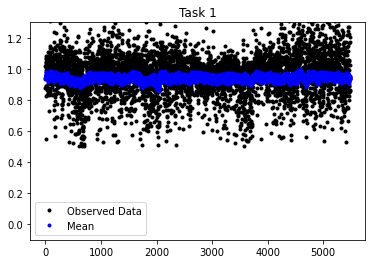

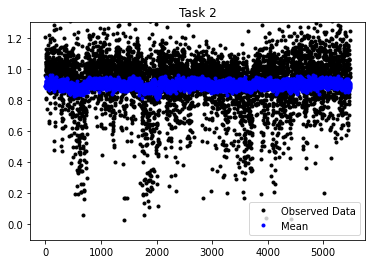

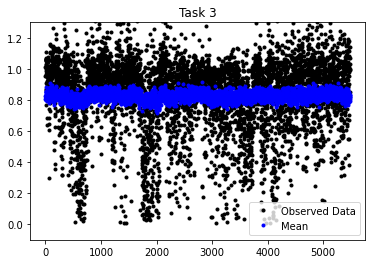

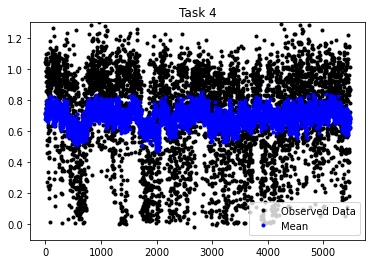

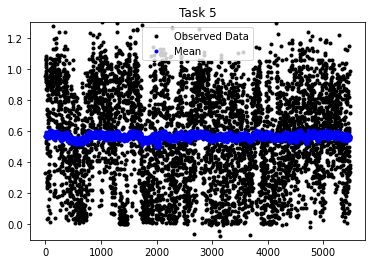

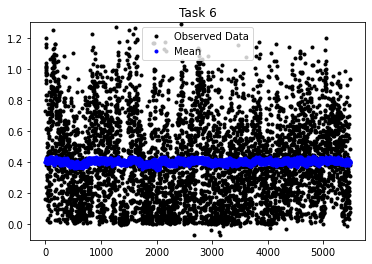

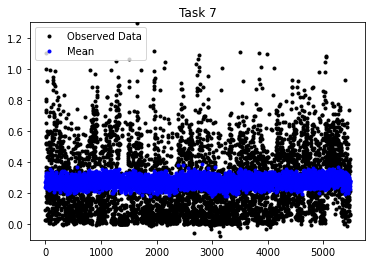

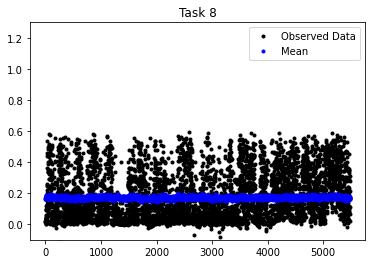

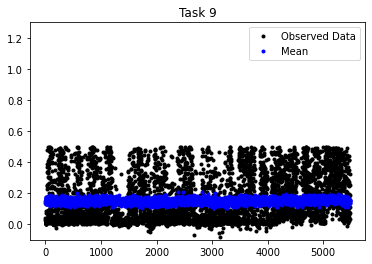

In [19]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
#fig, axs = plt.subplots(1, num_tasks, figsize=(4 * num_tasks, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

for task in range(num_tasks):
    # Plot training data as black stars
    plt.figure(task)
    plt.plot(test_y[:, task].detach().numpy(), 'k.')
    # Predictive mean as blue line
    plt.plot(mean[:, task].numpy(), '.b')
    # Shade in confidence
    #ax.fill_between(test_x.numpy(), lower[:, task].numpy(), upper[:, task].numpy(), alpha=0.5)
    plt.ylim([-0.1, 1.3])
    plt.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.title(f'Task {task + 1}')

#fig.tight_layout()
None

In [20]:
r2_scr = r2_score(test_y.T, mean.T, multioutput='raw_values')[:,None]
print("Median: ",np.median(r2_scr))
print("Mean: ",np.mean(r2_scr))
#r2_scr.shape

Median:  0.7580187149994084
Mean:  0.4590150971832652


In [296]:
print(model.covar_module.base_kernel.kernels[5].lengthscale)

tensor([[[5.5255e-02]],

        [[6.4887e+00]],

        [[7.2477e-01]],

        [[1.9101e-02]],

        [[2.2536e-01]],

        [[4.4355e-01]],

        [[1.6833e+01]],

        [[2.3994e+01]],

        [[6.0708e+01]]], grad_fn=<SoftplusBackward0>)


In [67]:
model.covar_module.base_kernel.lengthscale=torch.tensor([[[0.1]],[[0.6]],[[0.2]],[[0.7]]])

In [183]:
model.covar_module.base_kernel.lengthscale

In [166]:
Dim = Xtrain.shape[1]
split_dim = 2
"here is Dim and Not Dim-1, I alredy substracted the -1 before"
size_dims = (Dim)//split_dim

mykern = gpytorch.kernels.RBFKernel(active_dims=torch.tensor(list(np.arange(1,size_dims+1))),batch_shape=torch.Size([num_latents]))
#k = Cons(active_dims=list(np.arange(0,size_dims))) + Lin(active_dims=list(np.arange(0,size_dims)))*M12(1.0,lengthscales=scal*np.random.rand(size_dims),active_dims=list(np.arange(0,size_dims)))

#k = SE(1.0,lengthscales=scal*np.random.rand(size_dims),active_dims=list(np.arange(0,size_dims)))
#print(list(np.arange(0,size_dims)))
for i in range(1,split_dim):
    if i != (split_dim-1):
        mykern = mykern + gpytorch.kernels.RBFKernel(active_dims=torch.tensor(list(np.arange(size_dims*i+1,size_dims*i+size_dims+1))),batch_shape=torch.Size([num_latents]))
        print(torch.tensor(list(np.arange(size_dims*i+1,size_dims*i+size_dims+1))))
        #k = k + Cons(active_dims=list(np.arange(size_dims*i,size_dims*i+size_dims))) + Lin(active_dims=list(np.arange(size_dims*i,size_dims*i+size_dims)))*M12(1.0,lengthscales=scal*np.random.rand(size_dims),active_dims=list(np.arange(size_dims*i,size_dims*i+size_dims)))
        #k = k + SE(1.0,lengthscales=scal*np.random.rand(size_dims),active_dims=list(np.arange(size_dims*i,size_dims*i+size_dims)))
        #print(list(np.arange(size_dims*i,size_dims*i+size_dims)))
    else:
        mykern = mykern + gpytorch.kernels.RBFKernel(active_dims=torch.tensor(list(np.arange(size_dims*i+1,Dim+1))),batch_shape=torch.Size([num_latents]))
        print(torch.tensor(list(np.arange(size_dims*i+1,Dim+1))))
        #k = k + Cons(active_dims=list(np.arange(size_dims*i,Dim))) + Lin(active_dims=list(np.arange(size_dims*i,Dim)))* M12(1.0,lengthscales=scal*np.random.rand(size_dims+(Dim)%split_dim),active_dims=list(np.arange(size_dims*i,Dim)))
        #k = k + SE(1.0,lengthscales=scal*np.random.rand(size_dims+(Dim)%split_dim),active_dims=list(np.arange(size_dims*i,Dim)))
#list_k_q.append(k)

# self.covar_module = gpytorch.kernels.ScaleKernel(
#             gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
#             batch_shape=torch.Size([num_latents])

tensor([ 677,  678,  679,  680,  681,  682,  683,  684,  685,  686,  687,  688,
         689,  690,  691,  692,  693,  694,  695,  696,  697,  698,  699,  700,
         701,  702,  703,  704,  705,  706,  707,  708,  709,  710,  711,  712,
         713,  714,  715,  716,  717,  718,  719,  720,  721,  722,  723,  724,
         725,  726,  727,  728,  729,  730,  731,  732,  733,  734,  735,  736,
         737,  738,  739,  740,  741,  742,  743,  744,  745,  746,  747,  748,
         749,  750,  751,  752,  753,  754,  755,  756,  757,  758,  759,  760,
         761,  762,  763,  764,  765,  766,  767,  768,  769,  770,  771,  772,
         773,  774,  775,  776,  777,  778,  779,  780,  781,  782,  783,  784,
         785,  786,  787,  788,  789,  790,  791,  792,  793,  794,  795,  796,
         797,  798,  799,  800,  801,  802,  803,  804,  805,  806,  807,  808,
         809,  810,  811,  812,  813,  814,  815,  816,  817,  818,  819,  820,
         821,  822,  823,  824,  825,  8

In [164]:
k

RBFKernel(
  (raw_lengthscale_constraint): Positive()
)

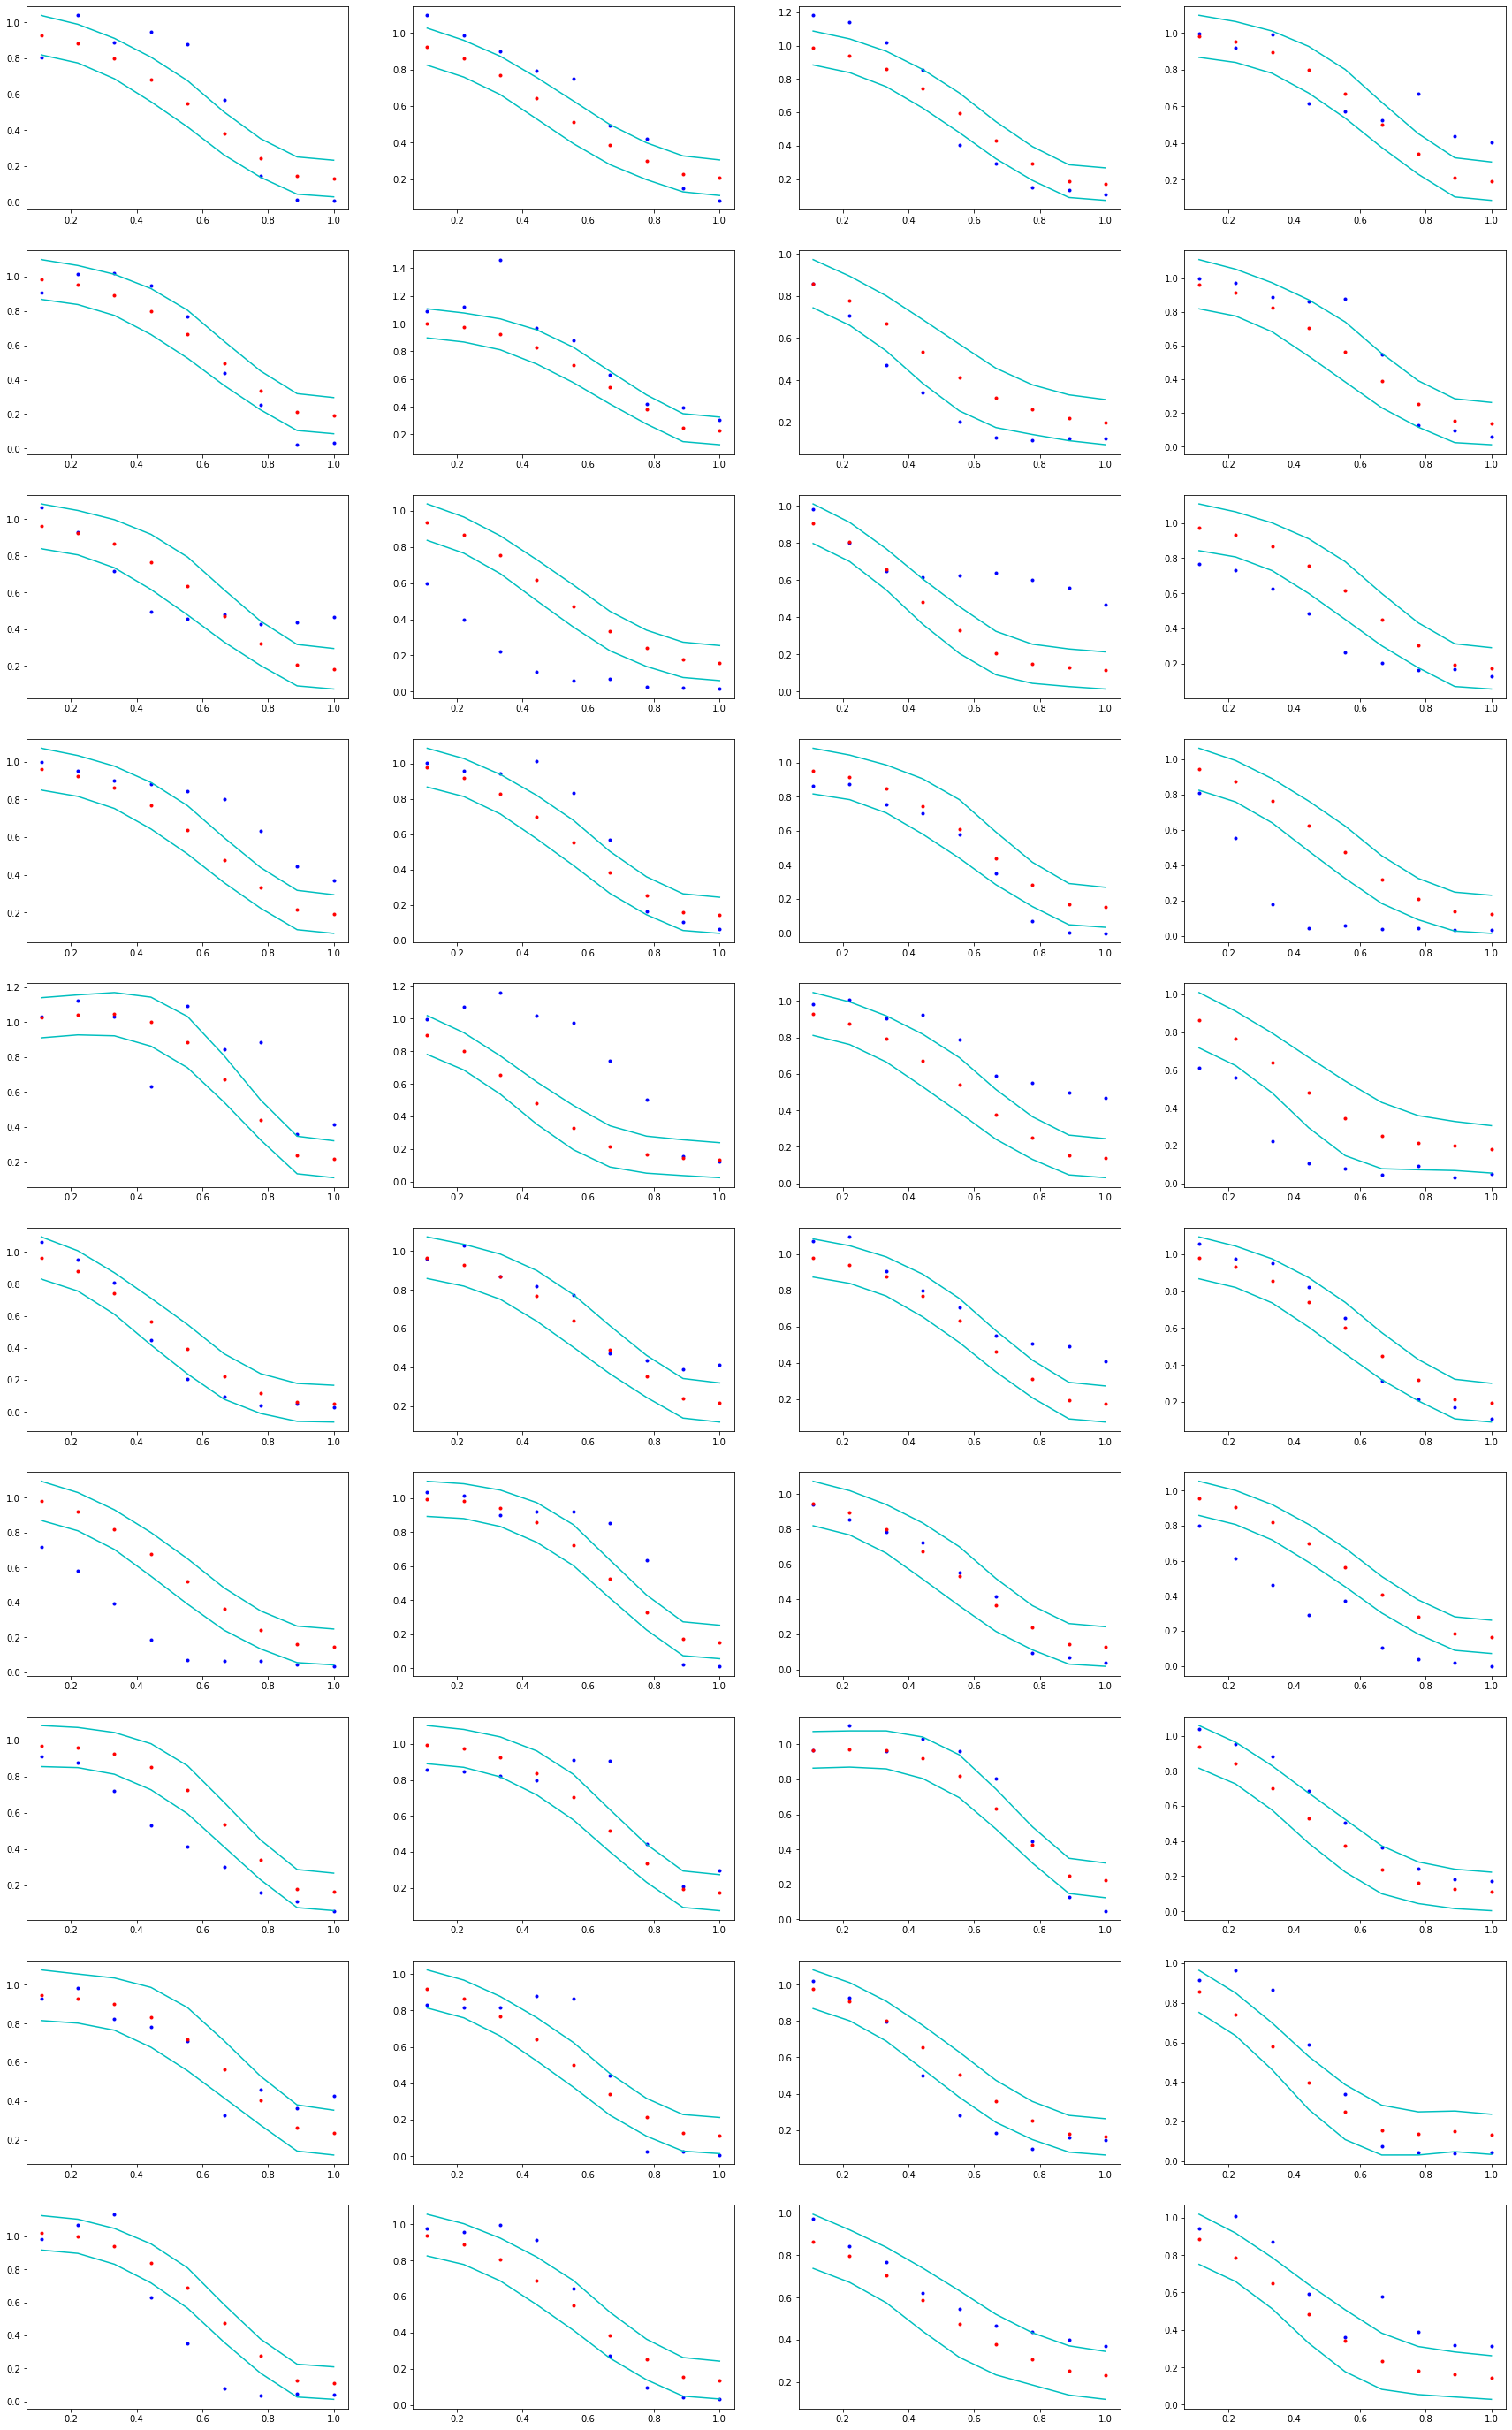

In [227]:
Nrow = 10
Ncolumn = 4
fig, axs = plt.subplots(Nrow, Ncolumn, figsize=(30,50))

#test_y, mean
for i in range(Nrow):
    for j in range(Ncolumn): 
        posy = np.random.randint(test_y.shape[0])
        axs[i, j].plot(np.linspace(0.11,1,9), test_y[posy,:],'.b')
        axs[i, j].plot(np.linspace(0.11,1,9), mean[posy,:],'.r')
        axs[i, j].plot(np.linspace(0.11,1,9), lower[posy,:],'-c')
        axs[i, j].plot(np.linspace(0.11,1,9), upper[posy,:],'-c')

In [92]:
likelihood.raw_task_noises#=torch.tensor([-1,-1,-1,-1,-1,-1,-1,-1,-1])

Parameter containing:
tensor([2.3449, 3.4594, 4.0393, 3.8626, 3.8383, 4.2147, 3.9125, 3.3786, 3.1791],
       requires_grad=True)

In [63]:
likelihood.raw_task_noises_constraint

TypeError: cannot assign 'torch.LongTensor' as parameter 'raw_task_noises' (torch.nn.Parameter or None expected)